<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Весна 2021</b></h3>

# Autoencoders


# Часть 1. Vanilla Autoencoder (10 баллов)

## 1.1. Подготовка данных (0.5 балла)


In [1]:
import random
import os
from pathlib import Path
import numpy as np
import pandas as pd
import skimage.io
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from matplotlib.gridspec import GridSpec
from IPython.display import clear_output
import copy

from torch.autograd import Variable
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# фиксация SEED
SEED = 0
RANDOM_STATE = SEED
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
# Подключение Google-диска для сохранения весов
from google.colab import drive
drive.mount('/content/drive/')
BASE_DIR = Path('/content/drive/MyDrive/autoencoders/')

Mounted at /content/drive/


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

!nvidia-smi

cuda
Sat Mar  4 14:00:46 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    24W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+--

In [ ]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    file_attrs = df[["photo_path","person","imagenum"]].copy()
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos, all_attrs, file_attrs

In [ ]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
data, attrs, file_attrs = fetch_dataset()

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done



Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

In [ ]:
train_photos, val_photos, train_attrs, val_attrs = train_test_split(data, attrs, 
                                                                    test_size=0.2, 
                                                                    shuffle=False, 
                                                                    random_state=RANDOM_STATE)

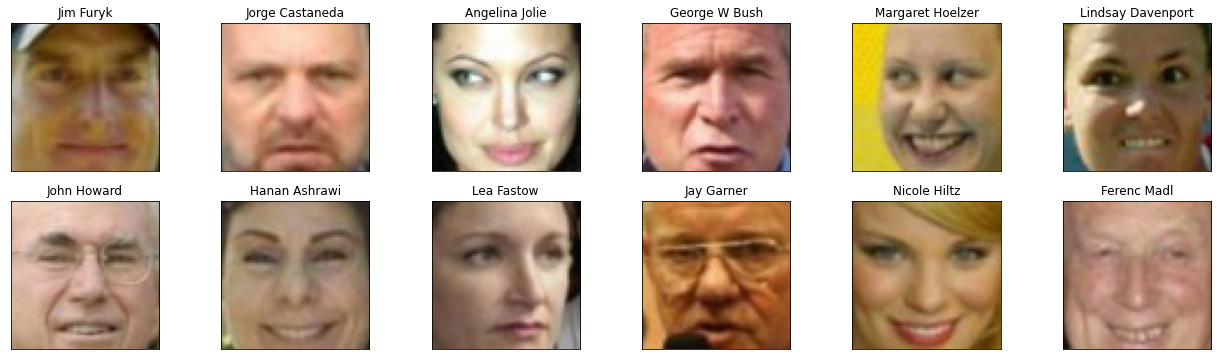

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=6, figsize=(22, 6), sharey=True, sharex=True)

for fig_x in ax.flatten():
    idx = random.randrange(0, train_photos.shape[0])
    fig_x.imshow(train_photos[idx])
    plt.xticks([])
    plt.yticks([])
    fig_x.set_title(file_attrs['person'].iloc[idx])
    plt.grid(True)
plt.show()

In [ ]:
BATCH_SIZE = 32

train_photos_t = torch.FloatTensor(train_photos).permute(0,3,1,2) # numpy.ndarray to tensor_float32 [32, 64, 64, 3] --> [32, 3, 64, 64]
val_photos_t = torch.FloatTensor(val_photos).permute(0,3,1,2) # numpy.ndarray to tensor_float32 [32, 64, 64, 3] --> [32, 3, 64, 64]

train_loader = torch.utils.data.DataLoader(train_photos_t, batch_size=BATCH_SIZE, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_photos_t, batch_size=BATCH_SIZE, num_workers=2)

In [ ]:
train_photos_t.size(), val_photos_t.size()

(torch.Size([10514, 3, 64, 64]), torch.Size([2629, 3, 64, 64]))

## 1.2. Архитектура модели (1.5 балла)
В этом разделе мы напишем и обучем обычный автоэнкодер.



<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">


^ напомню, что автоэнкодер выглядит вот так

In [ ]:
# наиболее часто используемые параметры обучения
init_channels = 32 # минимальный размер фильтров в сверточных слоях энкодера/декодера
latent_dim = 512 # размерность латентного вектора
image_channels = 3 # количество каналов изображения
lr = 3e-4 # базовое значение Learning Rate
epochs = 50 # количество эпох обучения
batchNorm_momentum = 0.1
kernel_size = 3 # базовый размер сверточного ядра

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [ ]:
from copy import deepcopy

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            # conv layer (depth from 3 --> 32), 3x3 kernels
            nn.Conv2d(in_channels=image_channels, out_channels=init_channels, kernel_size=kernel_size, stride=2, padding=1),
            nn.BatchNorm2d(num_features = init_channels, momentum = batchNorm_momentum),
            nn.ReLU(),
            # conv layer (depth from 32 --> 64), 3x3 kernels
            nn.Conv2d(in_channels=init_channels, out_channels=init_channels*2, kernel_size=kernel_size, stride=2, padding=1),
            nn.BatchNorm2d(num_features = init_channels*2, momentum = batchNorm_momentum),
            nn.ReLU(),
            # conv layer (depth from 64 --> 128), 3x3 kernels
            nn.Conv2d(in_channels=init_channels*2, out_channels=init_channels*4, kernel_size=kernel_size, stride=2, padding=1),
            nn.BatchNorm2d(num_features = init_channels*4, momentum = batchNorm_momentum),
            nn.ReLU(),
            nn.Flatten(start_dim=1),
            nn.Linear(8192, latent_dim),
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 8192),
            nn.Unflatten(dim=1, unflattened_size=(init_channels*4, 8, 8)),
            nn.ConvTranspose2d(in_channels=init_channels*4, out_channels=init_channels*2, kernel_size=kernel_size, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(num_features = init_channels*2, momentum= batchNorm_momentum),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=init_channels*2, out_channels=init_channels, kernel_size=kernel_size, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(num_features = init_channels, momentum= batchNorm_momentum),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=init_channels, out_channels=image_channels, kernel_size=kernel_size, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, sample):
        latent_code = self.encoder(sample)
        reconstruction = self.decoder(latent_code)
        return reconstruction, latent_code

    def sample(self, sample):
        reconstruction = self.decoder(sample)
        return reconstruction

In [5]:
from torchsummary import summary

In [ ]:
# просмотр архитектуры и параметров модели
summary(Autoencoder().to(device), (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 64, 16, 16]          18,496
       BatchNorm2d-5           [-1, 64, 16, 16]             128
              ReLU-6           [-1, 64, 16, 16]               0
            Conv2d-7            [-1, 128, 8, 8]          73,856
       BatchNorm2d-8            [-1, 128, 8, 8]             256
              ReLU-9            [-1, 128, 8, 8]               0
          Flatten-10                 [-1, 8192]               0
           Linear-11                  [-1, 512]       4,194,816
           Linear-12                 [-1, 8192]       4,202,496
        Unflatten-13            [-1, 128, 8, 8]               0
  ConvTranspose2d-14           [-1, 64,

## 1.3 Обучение (2 балла)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [ ]:
def train(model, optimizer, epochs=epochs, learning_rate=lr, used_sheduler=True):


    # Set default parameters for saving model weights
    best_model_weights = model.state_dict()
    best_loss_val = np.inf

    if used_sheduler:
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.95)

    criterion = nn.MSELoss() # mean square error loss

    outputs = []
    train_losses = []
    val_losses = []

    for epoch in tqdm(range(epochs)):

        model.train()  # train mode
        train_losses_per_epoch = []

        for data in train_loader:
            img = data.to(device)
            # set parameter gradients to zero
            optimizer.zero_grad()
            recon, _ = model(img)
            loss = criterion(recon, img) # forward-pass
            loss.backward()  # backward-pass
            optimizer.step()  # update weights
            train_losses_per_epoch.append(loss.item())

        train_losses.append(np.mean(train_losses_per_epoch))

        if used_sheduler:
            scheduler.step()

        model.eval()
        val_losses_per_epoch = []
        with torch.no_grad():
            for data in val_loader:
              img = data.to(device)
              recon, _ = model(img)
              loss = criterion(recon, img)
              val_losses_per_epoch.append(loss.item())
        val_losses.append(np.mean(val_losses_per_epoch))
        outputs.append((epoch, img, recon),)

        # Save best model weights
        if val_losses[epoch] < best_loss_val:
            best_loss_val = val_losses[epoch]
            best_model_weights = copy.deepcopy(model.state_dict())

        # Visualize tools
        clear_output(wait=True)

        fig = plt.figure(figsize=(12,6))
        fig.suptitle('%d / %d - train_loss: %f , val_loss: %f' % (epoch+1, epochs, np.mean(train_losses_per_epoch), np.mean(val_losses_per_epoch)),
                     y=1, fontsize = 16)

        gs1 = GridSpec(2, 5, left=0.0001, right=1.0, wspace=0.05)
        ax1 = fig.add_subplot(gs1[:-1, :1])
        ax2 = fig.add_subplot(gs1[:-1, 1])
        ax3 = fig.add_subplot(gs1[:-1, 2])
        ax4 = fig.add_subplot(gs1[:-1, 3])
        ax5 = fig.add_subplot(gs1[:-1, -1])

        ax6 = fig.add_subplot(gs1[-1, :1])
        ax7 = fig.add_subplot(gs1[-1, 1])
        ax8 = fig.add_subplot(gs1[-1, 2])
        ax9 = fig.add_subplot(gs1[-1, 3])
        ax10 = fig.add_subplot(gs1[-1, 4])

        gs2 = GridSpec(2, 2, left=1.1, right=2.0, hspace=0.05)
        ax11 = fig.add_subplot(gs2[:, :-1])

        axis =[ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11]
        for k in range(11):
          if k < 5:
              axis[k].imshow(img[k].detach().cpu().permute(1,2,0))
              axis[k].grid(False)
              axis[k].axis('off')
          elif 4 < k < 10:
              axis[k].imshow(recon[k-5].detach().cpu().permute(1,2,0))
              axis[k].set_title('Reconstruction')
              axis[k].grid(False)
              axis[k].axis('off')
          else:
              axis[k].plot(np.arange(len(train_losses)), train_losses, label='Train', color = "green")
              axis[k].plot(np.arange(len(val_losses)), val_losses, label='Validation', color = "orange")
              axis[k].set_xlabel('Epoch')
              axis[k].set_title('MSE loss', fontsize = 16)
              axis[k].legend()
              axis[k].legend(fontsize = 14)
              axis[k].grid(linestyle = "--")
              axis[k].tick_params(labelsize = 14)
              axis[k].set_xlabel("Epoch", fontsize = 14)
              axis[k].set_ylabel("Loss", fontsize = 14)
              axis[k].set_xlim(left = 0, right = len(train_losses))
              axis[k].set_ylim(bottom = 0, top = max(max(train_losses), max(val_losses))*1.2)

        #plt.tight_layout()
        plt.show()

    # load best model weights
    model.load_state_dict(best_model_weights)
    # очистка кеша

    data.to("cpu")
    img.to("cpu")
    recon.to("cpu")
    model.to("cpu")
    del data
    del img
    del recon
    del model
    torch.cuda.empty_cache()    


    return outputs, train_losses, val_losses

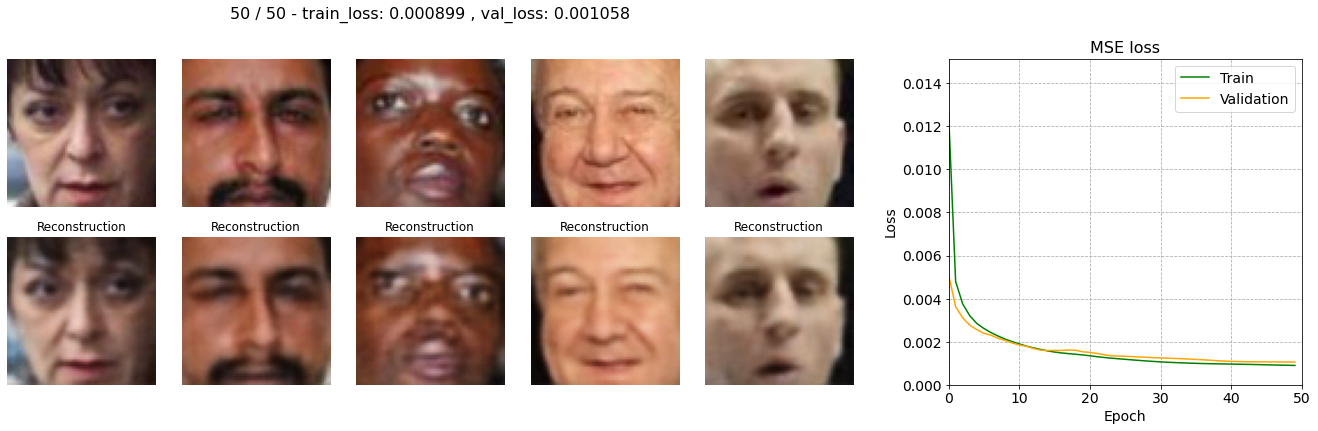

In [ ]:
model = Autoencoder().to(device)
optimizer = torch.optim.AdamW(model.parameters(),lr=lr, betas=(0.9, 0.999), eps=1e-8, weight_decay=1e-5, amsgrad=False)
outputs, train_losses, val_losses = train(model, optimizer)

In [ ]:
# Сохраняем веса модели
torch.save(model.state_dict(), Path(str(BASE_DIR) + str('/VanillaAE')))

In [ ]:
# загрузка весов
model = Autoencoder().to(device)
model.load_state_dict(torch.load(Path(str(BASE_DIR) + str('/VanillaAE')), map_location=torch.device('cuda')))
model.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=8192, out_features=512, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=512, out_features=8192, bias=True)
    (1): Unflatten(dim=1, unflattened_size=(128, 8, 8))
    (2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tr

Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

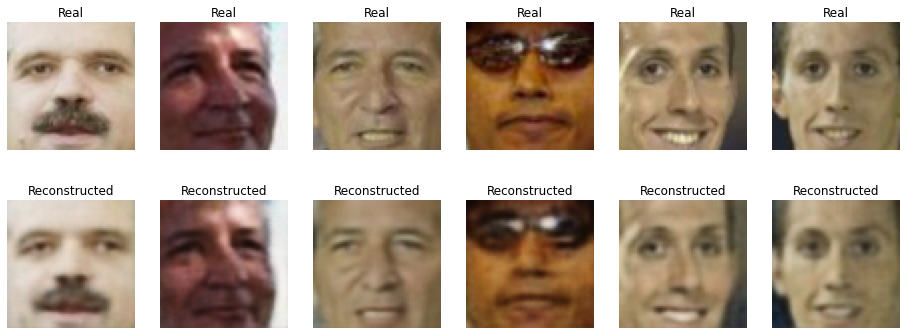

In [ ]:
#Выведем первые Х картинок и их реконструкций из val выборки на экран
images = next(iter(val_loader))
with torch.no_grad():
    reconstructed, _ = model(images.to(device))

fig, ax = plt.subplots(2, 6, figsize=(16, 6))
for i in range(2):
    for j in range(6):
        axes = ax[i, j]
        if i == 0:
            axes.imshow(images[j].permute(1,2,0))
            axes.set_title('Real')
        else:
            axes.imshow(reconstructed[j].cpu().permute(1,2,0))
            axes.set_title('Reconstructed')
        axes.axis('off')
plt.show()

Not bad, right? 

## 1.4. Sampling (2 балла)

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

__Подсказка:__Е сли вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

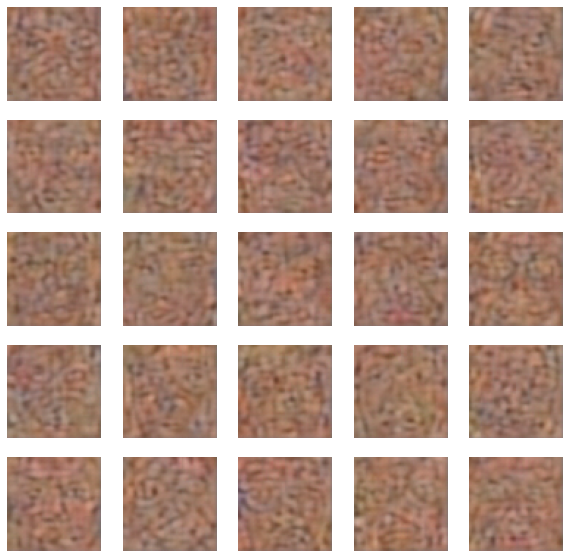

In [ ]:
# сгенерируем 25 рандомных векторов размера latent_space
z = np.random.randn(25, latent_dim)
output = model.sample(torch.FloatTensor(z).to(device))

plt.figure(figsize=(10, 10))
for i in range(output.shape[0]):
  plt.subplot(5, 5, i + 1)
  generated = output[i].permute(1,2,0).cpu().detach().numpy()
  plt.imshow(generated)
  plt.axis('off')

plt.show()

In [6]:
from scipy import stats
from scipy.stats import kurtosis, skew
import statistics

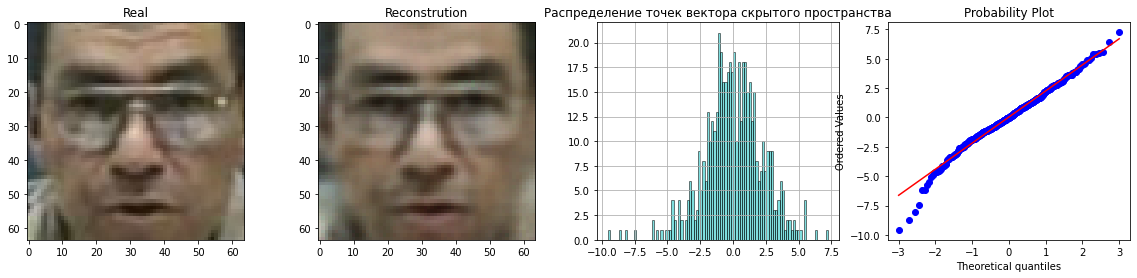

Эксцесс  1.3585467132676108
Ассиметрия  -0.330222679874432
Среднее значение  0.035783517954769195
Размах  16.824545
Дисперсия  4.974391293904272
Среднее отклонение  2.230334345766184


In [ ]:
# посмотрим на то, как выглядит реальный латентный вектор
# берем 1-ый батч из валидационого датасета
model.eval()
with torch.no_grad():
    for batch in val_loader:
      ground_truth = batch.numpy()
      break

# достаем из батча к примеру 9-ый по счету тензор размерности [1, 3, 128, 128]
gt_0 = torch.FloatTensor([ground_truth[8]]).to(device)

# получаем по нему латентный вектор и тензор с восстановленным изображением
recon, latent_vector = model(gt_0)

# смотрим результаты
fig, ax = plt.subplots(1, 4, figsize=(20, 4))
ax[0].set_title('Real')
ax[0].imshow(gt_0.squeeze().permute(1,2,0).detach().to('cpu').numpy())
ax[1].set_title('Reconstrution')
ax[1].imshow(recon.squeeze().permute(1,2,0).detach().to('cpu').numpy())
ax[2].set_title('Распределение точек вектора скрытого пространства')
ax[2].hist(latent_vector.detach().to('cpu'), bins=100, color='c', edgecolor='k', alpha=0.5)
ax[2].grid()
ax[3]=stats.probplot(latent_vector.detach()[0].to('cpu'), dist="norm", plot=plt)

plt.show()

# Оценим некоторые статистические параметры реального латентного вектора
print("Эксцесс ", kurtosis(latent_vector.detach().to('cpu').numpy()[0]))
print("Ассиметрия ", skew(latent_vector.detach().to('cpu').numpy()[0]))
print("Среднее значение ", sum(latent_vector.detach()[0].to('cpu').numpy())/len(latent_vector.detach()[0].to('cpu').numpy()))
print("Размах ", max(latent_vector.detach()[0].to('cpu').numpy()) - min(latent_vector.detach()[0].to('cpu').numpy()))
deviation_sum_of_data = 0
for x_i in latent_vector.detach()[0].to('cpu').numpy():
    deviation_sum_of_data += (x_i - statistics.mean(latent_vector.detach()[0].to('cpu').numpy()))**2
print("Дисперсия ", deviation_sum_of_data / (len(latent_vector.detach()[0].to('cpu').numpy()) - 1))
print("Среднее отклонение ", (deviation_sum_of_data / (len(latent_vector.detach()[0].to('cpu').numpy()) - 1))**0.5)

## Пайплайн рассчета мат.ожидания и сигмы по распределению признаков реальных латентных векторов, семплирование случайных векторов с учетом полученных стат. данных


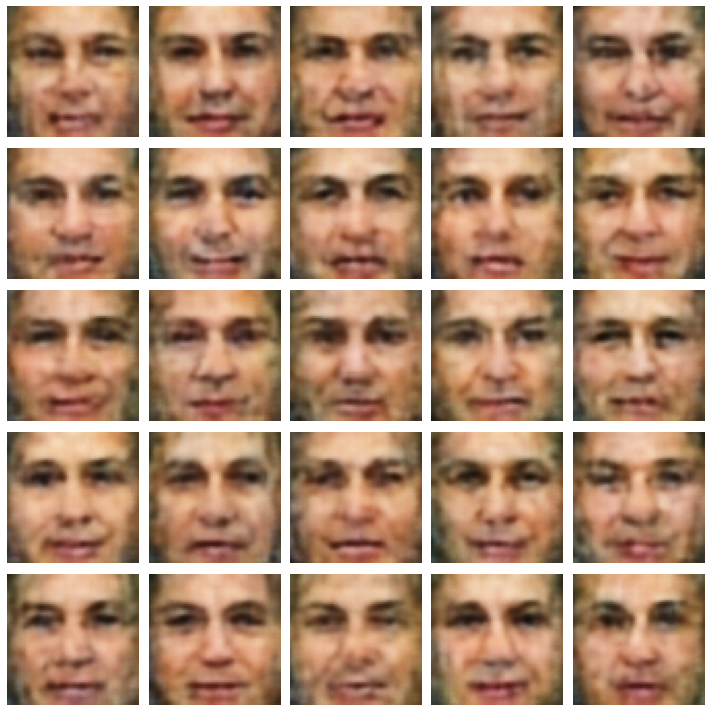

In [ ]:
count = 0
latents = torch.FloatTensor()
iterator = iter(train_loader)
for i in range(len(train_loader)):
    count += 1
    images = next(iterator)
    model.eval()
    with torch.no_grad():
        _, latent_vector = model(images.to(device))
    latents = torch.cat((latents, latent_vector.to('cpu')), dim=0)
    
mu = torch.mean(latents, axis=0)   #axis=0 рассчитывает mu поиндексно (попризнаково - от 0 до 511) по всем 10514 векторам
sigma = torch.std(latents, axis=0) #axis=0 рассчитывает sigma поиндексно (попризнаково - от 0 до 511) по всем 10514 векторам

# сгенерируем 25 рандомных векторов размера latent_space 
z = 0.5*sigma * torch.randn(25, latent_dim) + 2*mu # и добавим немного эмпирических коэффициентов 0.5* и 2*

# восстановленные результаты по скорректированному z
with torch.no_grad():
    output = model.sample(torch.FloatTensor(z).to(device))
# <выведите тут полученные картинки>
fig, ax = plt.subplots(5, 5, figsize=(10, 10))
for i in range(5):
    for j in range(5):
        axes = ax[i, j]
        axes.imshow(output[5*i+j].cpu().permute(1,2,0))
        axes.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# сохраним полученные латентные вектора всех исходных изображениий train датасета
df = pd.DataFrame(latents.numpy())

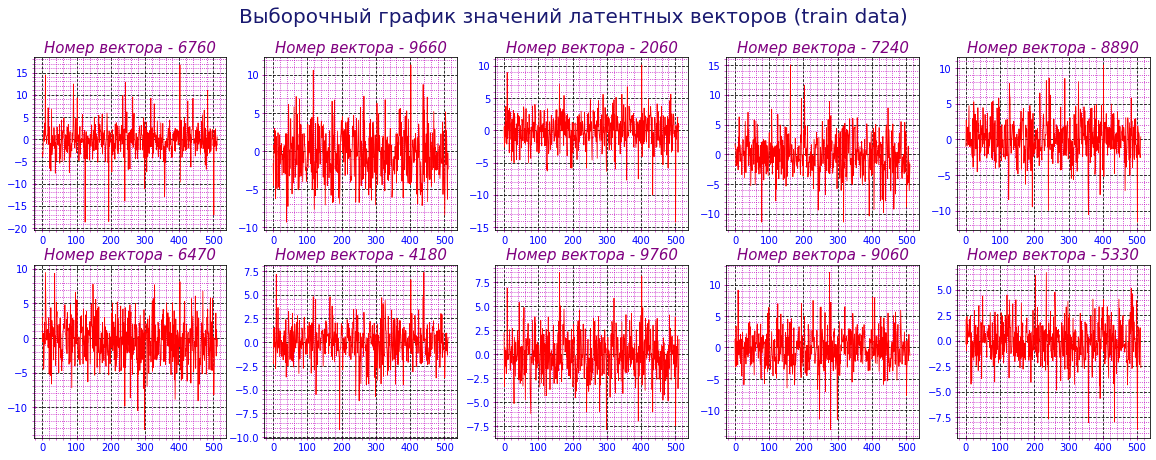

In [ ]:
fig, ax = plt.subplots(2, 5, figsize=(20, 7))
fig.suptitle('Выборочный график значений латентных векторов (train data)', fontsize=20, fontfamily = 'sans-serif', fontstyle = 'normal', color = 'midnightblue')

for i in range(2):
    for j in range(5):
      axes = ax[i, j]
      k = random.randrange(0, len(train_photos), 10)
      axes.set_xlabel('', fontsize = 20, color = 'darkslategrey', fontstyle = 'oblique')
      axes.set_ylabel('', fontsize = 20, color = 'darkslategrey', fontstyle = 'oblique')
      axes.tick_params(axis = 'both', which = 'major', direction = 'inout', color = 'm',
               labelcolor = 'b', bottom = True, left = True, labelbottom = True, labelleft = True)
      axes.tick_params(axis = 'both', which = 'minor', direction = 'out', color = 'm',
               labelcolor = 'r', bottom = True, left = True)

      axes.plot(df.iloc[k], color = 'r', linewidth = .8)
      axes.grid(which='major', color = 'k', linestyle = '--')
      axes.minorticks_on()
      axes.grid(which='minor', color = 'm', linestyle = ':')
      axes.set_title('Номер вектора - ' + str(k), fontfamily = 'sans-serif', fontstyle = 'italic',
                color = 'purple', fontsize = 15, pad = 5)
plt.show()

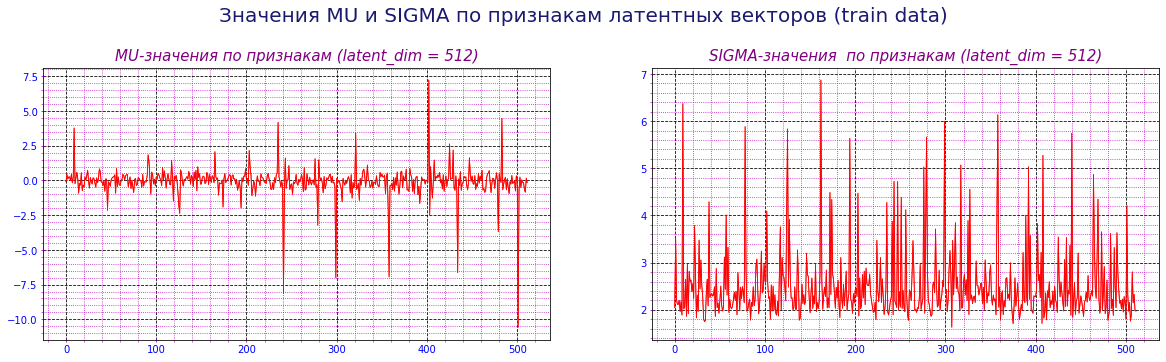

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle('Значения MU и SIGMA по признакам латентных векторов (train data)', fontsize=20, 
             fontfamily = 'sans-serif', fontstyle = 'normal', color = 'midnightblue', y=1.05)

for j in range(2):
  axes = ax[j]
  ax[0].plot(df.mean(axis=0), color = 'r', linewidth = .8)
  ax[1].plot(df.std(axis=0), color = 'r', linewidth = .8)
  k = random.randrange(0, latent_dim, 10)
  axes.set_xlabel('', fontsize = 20, color = 'darkslategrey', fontstyle = 'oblique')
  axes.set_ylabel('', fontsize = 20, color = 'darkslategrey', fontstyle = 'oblique')
  axes.tick_params(axis = 'both', which = 'major', direction = 'inout', color = 'm',
            labelcolor = 'b', bottom = True, left = True, labelbottom = True, labelleft = True)
  axes.tick_params(axis = 'both', which = 'minor', direction = 'out', color = 'm',
            labelcolor = 'r', bottom = True, left = True)

  axes.grid(which='major', color = 'k', linestyle = '--')
  axes.minorticks_on()
  axes.grid(which='minor', color = 'm', linestyle = ':')
  ax[0].set_title('MU-значения по признакам (latent_dim = 512)', fontfamily = 'sans-serif', fontstyle = 'italic',
            color = 'purple', fontsize = 15, pad = 8)
  ax[1].set_title('SIGMA-значения  по признакам (latent_dim = 512)', fontfamily = 'sans-serif', fontstyle = 'italic',
            color = 'purple', fontsize = 15, pad = 8)
plt.show()

### Промежуточный вывод: случайный латентный вектор в случае совпадения с распределением реального рандомного вектора по мат. ожиданию и дисперсии действительно генерирует образы, похожие на лица. Однако, качество получаемой картинки не очень хорошее без дополнительной ручной корректировки, поскольку распределение признаков реальных изображений в латентном пространстве не является нормальным.

## Time to make fun! (4 балла)

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [ ]:
# Грустные люди (20 шт)
sad_idx = attrs.sort_values('Smiling', ascending=True).where(attrs['Male'] < -2).dropna()[['Smiling', 'Male']].head(20).index.tolist()
# Улыбающиеся люди (20 шт)
smile_idx = attrs.sort_values('Smiling', ascending=False).where(attrs['Male'] < -2).dropna()[['Smiling', 'Male']].head(20).index.tolist()

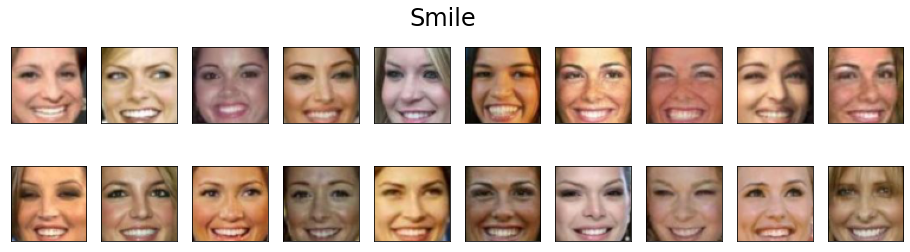

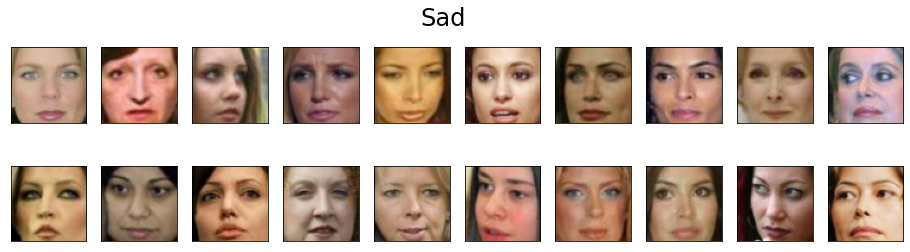

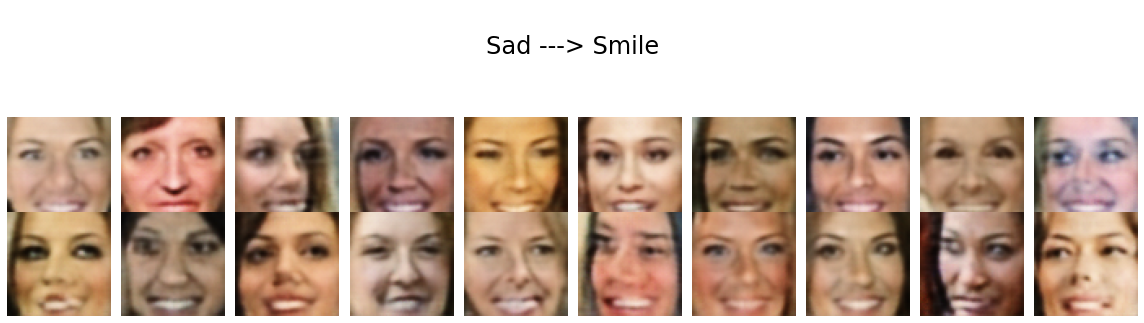

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=10, figsize=(16, 4), sharey=True, sharex=True)
count = 0

for fig_x in ax.flatten():
    fig_x.imshow(data[smile_idx[count]])
    plt.xticks([])
    plt.yticks([])
    count += 1
plt.suptitle('Smile', fontsize=24)
plt.show()


fig, ax = plt.subplots(nrows=2, ncols=10, figsize=(16, 4), sharey=True, sharex=True)
count = 0

for fig_x in ax.flatten():
    fig_x.imshow(data[sad_idx[count]])
    plt.xticks([])
    plt.yticks([])
    count += 1
plt.suptitle('Sad', fontsize=24)
plt.show()

latent_smile = torch.FloatTensor().to(device)
latent_sad = torch.FloatTensor().to(device)

# Вычисляем латентный вектор для всех улыбающихся людей
for idx in smile_idx:
  smile_image = torch.FloatTensor(data[idx]).permute(2, 0, 1).unsqueeze(0).to(device)
  with torch.no_grad():
    _, l_smile = model(smile_image)
  latent_smile = torch.cat((latent_smile, l_smile))

# Вычисляем латентный вектор для всех грустных людей
for idx in sad_idx:
  sad_image = torch.FloatTensor(data[idx]).permute(2, 0, 1).unsqueeze(0).to(device)
  with torch.no_grad():
    _, l_sad = model(sad_image)
  latent_sad = torch.cat((latent_sad, l_sad))

# Определяем вектор улыбки как разность между средним LatVec у улыбающихся и грустных
latent_smile_mean = torch.mean(latent_smile, axis=0)
latent_sad_mean = torch.mean(latent_sad, axis=0)
smile = latent_smile_mean - latent_sad_mean

# Добавим всем грустным немного Радости
latent_sad_with_smile = latent_sad + smile

with torch.no_grad():
    output = model.sample(latent_sad_with_smile)
# <выведите тут полученные картинки>
fig, ax = plt.subplots(2, 10, figsize=(16, 4))
for i in range(20):
    plt.subplot(2, 10, i+1)
    plt.imshow(output[i].cpu().permute(1,2,0))
    plt.axis('off')
plt.suptitle('\nSad ---> Smile', fontsize=24, y=1.12)    
plt.tight_layout()
plt.show()

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в `all_attrs`:)

# Часть 2: Variational Autoencoder (10 баллов) 

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [7]:
from torchvision import transforms


In [ ]:
batch_size = 32
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



## 2.1 Архитектура модели и обучение (2 балла)

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!

In [ ]:
# наиболее часто используемые параметры обучения
epochs = 50 # количество эпох обучения
lr = 3e-4 # базовое значение Learning Rate
init_channels = 32 # минимальный размер фильтров в сверточных слоях энкодера/декодера
image_channels = 1 # количество каналов изображения
vae_latent_dim = 4 # размерность латентного вектора (скрытого пространства)
kernel_size = 3 # базовый размер сверточного ядра
batchNorm_momentum = 0.1
num_classes = 10 # количество классов

In [ ]:
class VAE(nn.Module):
    def __init__(self):
        #<определите архитектуры encoder и decoder
        #помните, у encoder должны быть два "хвоста", 
        #т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma>
        super(VAE, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=image_channels, out_channels=init_channels, kernel_size=kernel_size, stride=2, padding=1),
            nn.BatchNorm2d(num_features = init_channels, momentum = batchNorm_momentum),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=init_channels, out_channels=init_channels*2, kernel_size=kernel_size, stride=2, padding=1),
            nn.BatchNorm2d(num_features = init_channels*2, momentum = batchNorm_momentum),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=init_channels*2, out_channels=init_channels*4, kernel_size=kernel_size, stride=2, padding=1),
            nn.BatchNorm2d(num_features = init_channels*4, momentum = batchNorm_momentum),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=init_channels*4, out_channels=init_channels*8, kernel_size=kernel_size, stride=2, padding=1),
            nn.BatchNorm2d(num_features = init_channels*8, momentum = batchNorm_momentum),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=init_channels*8, out_channels=init_channels*16, kernel_size=kernel_size, stride=2, padding=1),
            nn.BatchNorm2d(num_features = init_channels*16, momentum = batchNorm_momentum),
            nn.LeakyReLU())
        
        self.mu = nn.Linear(init_channels*16, vae_latent_dim)
        
        self.logsigma = nn.Linear(init_channels*16, vae_latent_dim)
        
        self.decoder_input = nn.Linear(vae_latent_dim, init_channels*16)
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=init_channels*16, out_channels=init_channels*8, kernel_size=kernel_size, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(num_features = init_channels*8, momentum = batchNorm_momentum),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=init_channels*8, out_channels=init_channels*4, kernel_size=kernel_size, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(num_features = init_channels*4, momentum = batchNorm_momentum),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=init_channels*4, out_channels=init_channels*2, kernel_size=kernel_size, stride=2, padding=1, output_padding=0),
            nn.BatchNorm2d(num_features = init_channels*2, momentum = batchNorm_momentum),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=init_channels*2, out_channels=init_channels, kernel_size=kernel_size, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(num_features = init_channels, momentum = batchNorm_momentum),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=init_channels, out_channels=image_channels, kernel_size=kernel_size, stride=2, padding=1, output_padding=1),
            nn.Sigmoid())

    def reparameterize(self, mu, logsigma):
        std = torch.exp(0.5 * logsigma)
        eps = torch.randn_like(std)
        sample = eps * std + mu
        return sample
       
    def encode(self, x):
        #<реализуйте forward проход энкодера
        #в качестве ваозвращаемых переменных -- mu и logsigma>
        x = self.encoder(x)
        x = torch.flatten(x, start_dim=1)
        mu = self.mu(x)
        logsigma = self.logsigma(x)
        return mu, logsigma
            
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            #<засемплируйте латентный вектор из нормального распределения с параметрами mu и sigma>
            samples = self.reparameterize(mu, logsigma)
            return samples
            
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu. 
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu
    
    def decode(self, z):
        #<реализуйте forward проход декодера
        #в качестве возвращаемой переменной -- reconstruction>
        z = self.decoder_input(z)
        z = z.view(-1, 512, 1, 1)
        reconstruction = self.decoder(z)
        return reconstruction

    def forward(self, x):
        #<используя encode и decode, реализуйте forward проход автоэнкодера
        #в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction>
        mu, logsigma = self.encode(x)
        z = self.reparameterize(mu, logsigma)
        reconstruction = self.decode(z)
        return reconstruction, mu, logsigma

    def get_latent_vector(self, x):
        mu, logsigma = self.encode(x)
        z = self.reparameterize(mu, logsigma)
        return z

In [ ]:
summary(VAE().to(device), (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 14, 14]             320
       BatchNorm2d-2           [-1, 32, 14, 14]              64
         LeakyReLU-3           [-1, 32, 14, 14]               0
            Conv2d-4             [-1, 64, 7, 7]          18,496
       BatchNorm2d-5             [-1, 64, 7, 7]             128
         LeakyReLU-6             [-1, 64, 7, 7]               0
            Conv2d-7            [-1, 128, 4, 4]          73,856
       BatchNorm2d-8            [-1, 128, 4, 4]             256
         LeakyReLU-9            [-1, 128, 4, 4]               0
           Conv2d-10            [-1, 256, 2, 2]         295,168
      BatchNorm2d-11            [-1, 256, 2, 2]             512
        LeakyReLU-12            [-1, 256, 2, 2]               0
           Conv2d-13            [-1, 512, 1, 1]       1,180,160
      BatchNorm2d-14            [-1, 51

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [ ]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    #loss = <напишите код для KL-дивергенции, пользуясь формулой выше>
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    #loss = <binary cross-entropy>
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    #return <соедините тут две компоненты лосса. Mind the sign!>
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

И обучим модель:

In [ ]:
criterion = loss_vae
vaeautoencoder = VAE().to(device)
optimizer = torch.optim.AdamW(vaeautoencoder.parameters(),lr=lr, betas=(0.9, 0.999), eps=1e-8, weight_decay=1e-5, amsgrad=False)

In [ ]:
def train_vae(model, optimizer, criterion, epochs, train_loader, val_loader, is_scheduler=True):
    train_losses = []
    val_losses = []
    
    # Set default parameters for saving model weights
    best_model_weights = model.state_dict()
    best_loss_val = np.inf
    
    if is_scheduler:
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.95)
        
    for epoch in range(epochs):
        # Train mode
        model.train()
        train_losses_per_epoch = []
        for _, X_batch in enumerate(train_loader):
            optimizer.zero_grad()
            X_batch = X_batch[0].to(device)
            reconstructed, mu, logsigma = model(X_batch)
            loss = criterion(X_batch, mu, logsigma, reconstructed)
            loss.backward()
            optimizer.step()
            train_losses_per_epoch.append(loss.item())
        
        train_loss_mean = np.mean(train_losses_per_epoch)
        train_losses.append(train_loss_mean)
        
        if is_scheduler:
            scheduler.step()
        
        # Validation
        model.eval()
        val_losses_per_epoch = []
        with torch.no_grad():
            for X_batch_val in val_loader:
                X_batch_val = X_batch_val[0].to(device)
                reconstructed_val, mu_val, logsigma_val = model(X_batch_val)
                loss_val = criterion(X_batch_val, mu_val, logsigma_val, reconstructed_val)
                val_losses_per_epoch.append(loss_val.item())
        
        val_loss_mean = np.mean(val_losses_per_epoch)
        val_losses.append(np.mean(val_loss_mean))
        
        # Save best model weights
        if val_loss_mean < best_loss_val:
            best_loss_val = val_loss_mean
            best_model_weights = copy.deepcopy(model.state_dict())
            
        # Visualisations
        clear_output(wait=True)
        fig = plt.figure(figsize=(12,6))
        fig.suptitle(f"{epoch+1}/{epochs}, train_loss:{round(train_loss_mean, 6)}, val_loss:{round(val_loss_mean, 6)}", fontsize = 16)

        gs1 = GridSpec(2, 5, left=0.0001, right=1.0, wspace=0.05)
        ax1 = fig.add_subplot(gs1[:-1, :1])
        ax2 = fig.add_subplot(gs1[:-1, 1])
        ax3 = fig.add_subplot(gs1[:-1, 2])
        ax4 = fig.add_subplot(gs1[:-1, 3])
        ax5 = fig.add_subplot(gs1[:-1, -1])

        ax6 = fig.add_subplot(gs1[-1, :1])
        ax7 = fig.add_subplot(gs1[-1, 1])
        ax8 = fig.add_subplot(gs1[-1, 2])
        ax9 = fig.add_subplot(gs1[-1, 3])
        ax10 = fig.add_subplot(gs1[-1, 4])

        gs2 = GridSpec(2, 2, left=1.1, right=2.0, hspace=0.05)
        ax11 = fig.add_subplot(gs2[:, :-1])

        axis =[ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11]
        for k in range(11):
          if k < 5:
              axis[k].imshow(X_batch_val[k].detach().cpu().squeeze(0), cmap='gray')
              axis[k].set_title('Real / ' + str(k+1))
              axis[k].grid(False)
              axis[k].axis('off')
          elif 4 < k < 10:
              axis[k].imshow(reconstructed_val[k-5].detach().cpu().squeeze(0), cmap='gray')
              axis[k].set_title('Reconstruction')
              axis[k].grid(False)
              axis[k].axis('off')
          else:
              axis[k].plot(np.arange(len(train_losses)), train_losses, label='Train', color = "green")
              axis[k].plot(np.arange(len(val_losses)), val_losses, label='Validation', color = "orange")
              axis[k].set_xlabel('Epoch')
              axis[k].set_title('MSE loss', fontsize = 16)
              axis[k].legend()
              axis[k].legend(fontsize = 14)
              axis[k].grid(linestyle = "--")
              axis[k].tick_params(labelsize = 14)
              axis[k].set_xlabel("Epoch", fontsize = 14)
              axis[k].set_ylabel("Loss", fontsize = 14)
              axis[k].set_xlim(left = 0, right = len(train_losses))
              axis[k].set_ylim(bottom = 3500, top = max(max(train_losses), max(val_losses))*1.05)

        #plt.tight_layout()
        plt.show()

        # Delete cache
        X_batch.to('cpu')
        del X_batch
        X_batch_val.to('cpu')
        del X_batch_val
        torch.cuda.empty_cache()
        
        # load best model weights
        model.load_state_dict(best_model_weights)

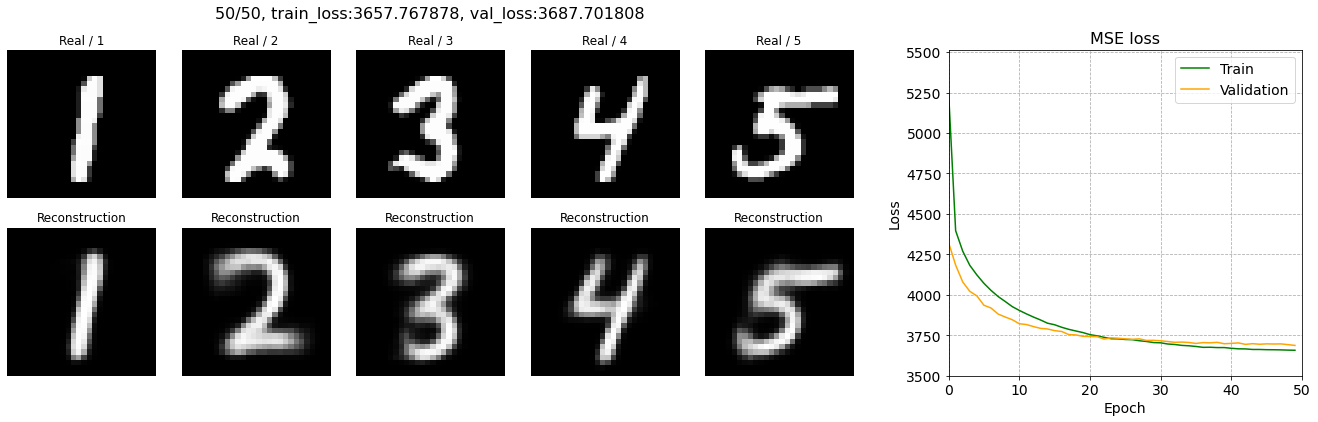

In [ ]:
train_vae(model=vaeautoencoder, optimizer=optimizer, criterion=criterion, epochs=epochs, train_loader=train_loader, val_loader=test_loader)

In [ ]:
# Сохраняем веса модели
torch.save(vaeautoencoder.state_dict(), Path(str(BASE_DIR) + str('/vae')))

In [ ]:
# загрузка весов
vaeautoencoder = VAE().to(device)
vaeautoencoder.load_state_dict(torch.load(Path(str(BASE_DIR) + str('/vae')), map_location=torch.device('cuda')))
vaeautoencoder.eval()

VAE(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.01)
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

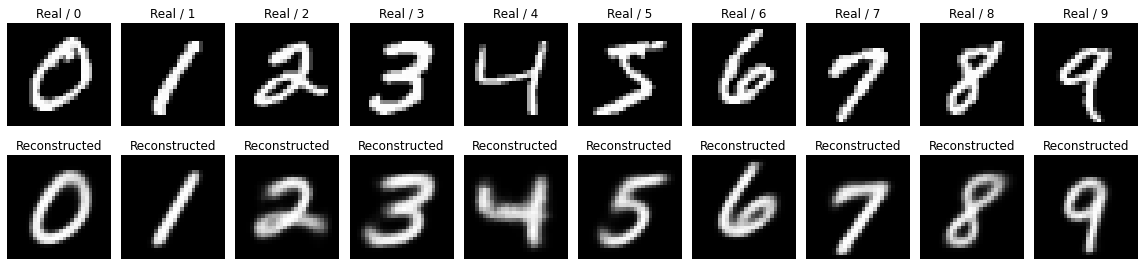

In [ ]:
fig, ax = plt.subplots(2, 10, figsize=(16, 4))
for i in range(10):
    for j in train_dataset:
        if j[1] == i:
            image = torch.FloatTensor(j[0]).unsqueeze(0)
            vaeautoencoder.eval()
            with torch.no_grad():
                reconstructed, mu, logsigma = vaeautoencoder(image.to(device))
            ax[0, i].imshow(torch.squeeze(image.cpu()), cmap='gray')
            ax[0, i].axis('off')
            ax[0, i].set_title('Real / '+ str(i))
            ax[1, i].imshow(torch.squeeze(reconstructed.cpu()), cmap='gray')
            ax[1, i].axis('off')
            ax[1, i].set_title('Reconstructed')
            break
plt.tight_layout()
plt.show()

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

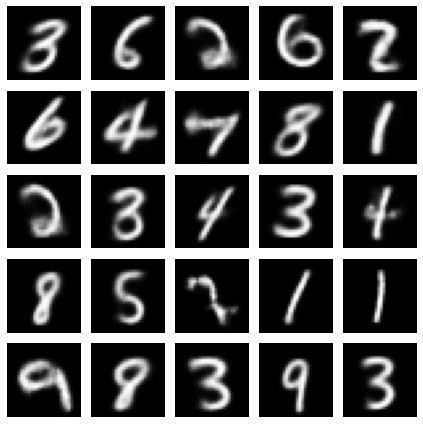

In [ ]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
z = np.array([np.random.normal(0, 1, vae_latent_dim) for i in range(25)])
z = torch.FloatTensor(z)
vaeautoencoder.eval()
with torch.no_grad():
    output = vaeautoencoder.decode(z.to(device))
# <выведите тут полученные картинки>
fig, ax = plt.subplots(5, 5, figsize=(6, 6))
for i in range(5):
    for j in range(5):
        axes = ax[i, j]
        axes.imshow(output[5*i+j].cpu().squeeze(0), cmap='gray')
        axes.axis('off')
plt.tight_layout()
plt.show()

## 2.2. Latent Representation (2 балла)

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве. 

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве. 

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

In [ ]:
# Список всех меток
labels = [i[1] for i in test_dataset]

latents = torch.FloatTensor()
iterator = iter(test_loader)
for i in range(len(test_loader)):
    images = next(iterator)
    images = images[0]
    vaeautoencoder.eval()
    with torch.no_grad():
        latent = vaeautoencoder.get_latent_vector(images.to(device))
    latents = torch.cat((latents, latent.cpu()))

In [8]:
from sklearn.manifold import TSNE
import seaborn as sns

In [ ]:
import warnings
warnings.filterwarnings("ignore")

latents_tsne = TSNE(n_components=2).fit_transform(latents)

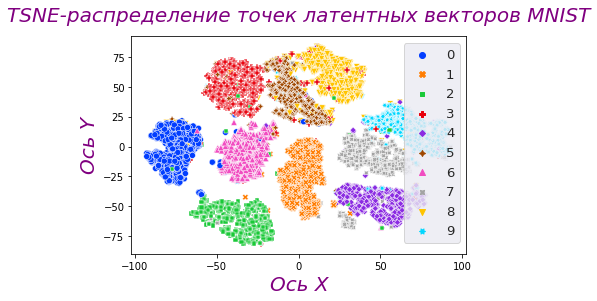

In [ ]:
fig, ax = plt.subplots()
sns.set(rc={'figure.figsize': (15, 8)}, font_scale=1.2, style='darkgrid')
sns.scatterplot(x = latents_tsne[:, 0], y = latents_tsne[:, 1], hue=labels, palette='bright', style=labels)
ax.set_title('TSNE-распределение точек латентных векторов MNIST', fontsize =20, color = 'purple', fontfamily = 'sans-serif', fontstyle = 'italic', pad = 15)
ax.set_xlabel('Ось X', fontsize =20, color = 'purple', fontfamily = 'sans-serif', fontstyle = 'italic')
ax.set_ylabel('Ось Y', fontsize =20, color = 'purple', fontfamily = 'sans-serif', fontstyle = 'italic')
plt.show()

Что вы думаете о виде латентного представления?

Полученные числовые кластеры хорошо различимы визуально и имеют достаточно четкие границы для последующего анализа. Количество ложно-положительных срабатываний в большей степени характерно для цифр с округлыми формами. В то время как единицы определяются наиболее точно.

__Congrats v2.0!__

## 2.3. Conditional VAE (6 баллов)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер. 
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица). 
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки. 

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

In [9]:
batch_size = 32
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



In [10]:
# наиболее часто используемые параметры обучения
epochs = 50 # количество эпох обучения
lr = 3e-4 # базовое значение Learning Rate
init_channels = 32 # минимальный размер фильтров в сверточных слоях энкодера/декодера
image_channels = 1 # количество каналов изображения
cvae_latent_dim = 4 # размерность латентного вектора (скрытого пространства)
kernel_size = 3 # базовый размер сверточного ядра
batchNorm_momentum = 0.1 # параметры нормализации
num_classes = 10 # количество классов
img_size = 28 # размер изображения

In [11]:
class CVAE(nn.Module):
    def __init__(self):
        #<определите архитектуры encoder и decoder
        #помните, у encoder должны быть два "хвоста", 
        #т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma>
        super(CVAE, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=image_channels, out_channels=init_channels, kernel_size=kernel_size, stride=2, padding=1),
            nn.BatchNorm2d(num_features = init_channels, momentum = batchNorm_momentum),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=init_channels, out_channels=init_channels*2, kernel_size=kernel_size, stride=2, padding=1),
            nn.BatchNorm2d(num_features = init_channels*2, momentum = batchNorm_momentum),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=init_channels*2, out_channels=init_channels*4, kernel_size=kernel_size, stride=2, padding=1),
            nn.BatchNorm2d(num_features = init_channels*4, momentum = batchNorm_momentum),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=init_channels*4, out_channels=init_channels*8, kernel_size=kernel_size, stride=2, padding=1),
            nn.BatchNorm2d(num_features = init_channels*8, momentum = batchNorm_momentum),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=init_channels*8, out_channels=init_channels*16, kernel_size=kernel_size, stride=2, padding=1),
            nn.BatchNorm2d(num_features = init_channels*16, momentum = batchNorm_momentum),
            nn.LeakyReLU())
        
        self.mu = nn.Linear(init_channels*16, cvae_latent_dim)
        
        self.logsigma = nn.Linear(init_channels*16, cvae_latent_dim)
        
        self.embed_class = nn.Linear(num_classes, img_size * img_size)
        
        # в in_channels добавлен дополнительный фильтр для меток (label)
        self.embed_data = nn.ConvTranspose2d(in_channels=image_channels + 1, out_channels=image_channels, kernel_size=1, padding=0, output_padding=0)
        
        self.decoder_input = nn.Linear(cvae_latent_dim + num_classes, init_channels*16)
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=init_channels*16, out_channels=init_channels*8, kernel_size=kernel_size, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(num_features = init_channels*8, momentum = batchNorm_momentum),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=init_channels*8, out_channels=init_channels*4, kernel_size=kernel_size, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(num_features = init_channels*4, momentum = batchNorm_momentum),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=init_channels*4, out_channels=init_channels*2, kernel_size=kernel_size, stride=2, padding=1, output_padding=0),
            nn.BatchNorm2d(num_features = init_channels*2, momentum = batchNorm_momentum),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=init_channels*2, out_channels=init_channels, kernel_size=kernel_size, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(num_features = init_channels, momentum = batchNorm_momentum),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=init_channels, out_channels=image_channels, kernel_size=kernel_size, stride=2, padding=1, output_padding=1),
            nn.Sigmoid())
        
    def reparameterize(self, mu, logsigma):
        std = torch.exp(0.5 * logsigma)
        eps = torch.randn_like(std)
        sample = eps * std + mu
        return sample

    def encode(self, x, label):
        #<реализуйте forward проход энкодера
        #в качестве ваозвращаемых переменных -- mu, logsigma и класс картинки>
        labels = F.one_hot(label, num_classes=10)
        labels = labels.type_as(torch.FloatTensor()).to(device)
        embedded_class = self.embed_class(labels)
        embedded_class = embedded_class.view(-1, 28, 28).unsqueeze(1)
        x = torch.cat([x, embedded_class], dim=1)
        x = self.embed_data(x)
        x = self.encoder(x)
        x = torch.flatten(x, start_dim=1)
        mu = self.mu(x)
        logsigma = self.logsigma(x)
        return mu, logsigma, labels # labels = class_num
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            #<засемплируйте латентный вектор из нормального распределения с параметрами mu и sigma>
            samples = self.reparameterize(mu, logsigma)
            return samples        
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu. 
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu
    
    def decode(self, z, label):
        #<реализуйте forward проход декодера
        #в качестве возвращаемой переменной -- reconstruction>
        labels = F.one_hot(label, num_classes=10)
        labels = labels.type_as(torch.FloatTensor()).to(device)
        z = torch.cat([z, labels], dim=1)
        z = self.decoder_input(z)
        z = z.view(-1, 512, 1, 1)
        reconstruction = self.decoder(z)
        return reconstruction

    def forward(self, x, label):
        #<используя encode и decode, реализуйте forward проход автоэнкодера
        #в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction>
        mu, logsigma, labels = self.encode(x, label)
        z = self.reparameterize(mu, logsigma)
        z = torch.cat([z, labels], dim=1)
        z = self.decoder_input(z)
        z = z.view(-1, 512, 1, 1)
        reconstruction = self.decoder(z)
        return reconstruction, mu, logsigma
    
    def get_latent_vector(self, x, label):
        mu, logsigma, labels = self.encode(x, label)
        z = self.reparameterize(mu, logsigma)
        return z

In [15]:
!pip install torchinfo
from torchinfo import summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [16]:
for batch in train_loader:
  image, label = batch
  break
summary(model=CVAE().to(device), input_data=[image, label])

Layer (type:depth-idx)                   Output Shape              Param #
CVAE                                     [32, 1, 28, 28]           --
├─Linear: 1-1                            [32, 784]                 8,624
├─ConvTranspose2d: 1-2                   [32, 1, 28, 28]           3
├─Sequential: 1-3                        [32, 512, 1, 1]           --
│    └─Conv2d: 2-1                       [32, 32, 14, 14]          320
│    └─BatchNorm2d: 2-2                  [32, 32, 14, 14]          64
│    └─LeakyReLU: 2-3                    [32, 32, 14, 14]          --
│    └─Conv2d: 2-4                       [32, 64, 7, 7]            18,496
│    └─BatchNorm2d: 2-5                  [32, 64, 7, 7]            128
│    └─LeakyReLU: 2-6                    [32, 64, 7, 7]            --
│    └─Conv2d: 2-7                       [32, 128, 4, 4]           73,856
│    └─BatchNorm2d: 2-8                  [32, 128, 4, 4]           256
│    └─LeakyReLU: 2-9                    [32, 128, 4, 4]           --
│ 

In [17]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции
    """
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

In [18]:
criterion = loss_vae
cvaeautoencoder = CVAE().to(device)
optimizer = torch.optim.AdamW(cvaeautoencoder.parameters(),lr=lr, betas=(0.9, 0.999), eps=1e-8, weight_decay=1e-5, amsgrad=False)

In [19]:
def train_cvae(model, optimizer, criterion, epochs, train_loader, val_loader, is_scheduler=True):
    train_losses = []
    val_losses = []
    
    # Set default parameters for saving model weights
    best_model_weights = model.state_dict()
    best_loss_val = np.inf
    
    if is_scheduler:
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.95)
        
    for epoch in range(epochs):
        # Train mode
        model.train()

        train_losses_per_epoch = []
        for _, X_batch in enumerate(train_loader):
            optimizer.zero_grad()
            images, labels = X_batch
            images = images.to(device)
            labels = labels.to(device)
            reconstructed, mu, logsigma = model(images, labels)
            loss = criterion(images, mu, logsigma, reconstructed)
            loss.backward()
            optimizer.step()
            train_losses_per_epoch.append(loss.item())
        
        train_loss_mean = np.mean(train_losses_per_epoch)
        train_losses.append(train_loss_mean)
        
        if is_scheduler:
            scheduler.step()
        
        # Validation
        model.eval()
        val_losses_per_epoch = []
        with torch.no_grad():
            for X_batch_val in val_loader:
                images_val, labels_val = X_batch_val
                images_val = images_val.to(device)
                labels_val = labels_val.to(device)
                reconstructed_val, mu_val, logsigma_val = model(images_val, labels_val)
                loss_val = criterion(images_val, mu_val, logsigma_val, reconstructed_val)
                val_losses_per_epoch.append(loss_val.item())
        
        val_loss_mean = np.mean(val_losses_per_epoch)
        val_losses.append(np.mean(val_loss_mean))
        
        # Save best model weights
        if val_loss_mean < best_loss_val:
            best_loss_val = val_loss_mean
            best_model_weights = copy.deepcopy(model.state_dict())
            
        # Visualisations
        clear_output(wait=True)

        fig = plt.figure(figsize=(12,6))
        fig.suptitle(f"{epoch+1}/{epochs}, train_loss:{round(train_loss_mean, 6)}, val_loss:{round(val_loss_mean, 6)}", fontsize = 16)

        gs1 = GridSpec(2, 5, left=0.0001, right=1.0, wspace=0.05)
        ax1 = fig.add_subplot(gs1[:-1, :1])
        ax2 = fig.add_subplot(gs1[:-1, 1])
        ax3 = fig.add_subplot(gs1[:-1, 2])
        ax4 = fig.add_subplot(gs1[:-1, 3])
        ax5 = fig.add_subplot(gs1[:-1, -1])

        ax6 = fig.add_subplot(gs1[-1, :1])
        ax7 = fig.add_subplot(gs1[-1, 1])
        ax8 = fig.add_subplot(gs1[-1, 2])
        ax9 = fig.add_subplot(gs1[-1, 3])
        ax10 = fig.add_subplot(gs1[-1, 4])

        gs2 = GridSpec(2, 2, left=1.1, right=2.0, hspace=0.05)
        ax11 = fig.add_subplot(gs2[:, :-1])

        axis =[ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11]
        for k in range(11):
          if k < 5:
              axis[k].imshow(images_val[k].detach().cpu().squeeze(0), cmap='gray')
              axis[k].set_title('Real / ' + str(k+1))
              axis[k].grid(False)
              axis[k].axis('off')
          elif 4 < k < 10:
              axis[k].imshow(reconstructed_val[k-5].detach().cpu().squeeze(0), cmap='gray')
              axis[k].set_title('Reconstruction')
              axis[k].grid(False)
              axis[k].axis('off')
          else:
              axis[k].plot(np.arange(len(train_losses)), train_losses, label='Train', color = "green")
              axis[k].plot(np.arange(len(val_losses)), val_losses, label='Validation', color = "orange")
              axis[k].set_xlabel('Epoch')
              axis[k].set_title('MSE loss', fontsize = 16)
              axis[k].legend()
              axis[k].legend(fontsize = 14)
              axis[k].grid(linestyle = "--")
              axis[k].tick_params(labelsize = 14)
              axis[k].set_xlabel("Epoch", fontsize = 14)
              axis[k].set_ylabel("Loss", fontsize = 14)
              axis[k].set_xlim(left = 0, right = len(train_losses))
              axis[k].set_ylim(bottom = 3400, top = max(max(train_losses), max(val_losses))*1.05)

        #plt.tight_layout()
        plt.show()
        
        # Delete cache
        images.to('cpu')
        del images
        images_val.to('cpu')
        del images_val
        torch.cuda.empty_cache()
        
        # load best model weights
        model.load_state_dict(best_model_weights)

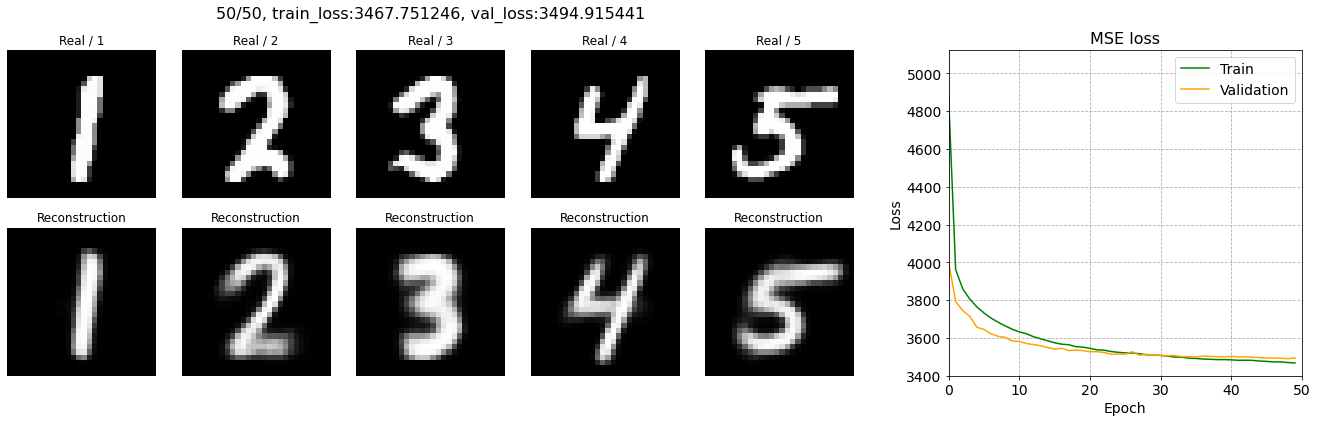

In [20]:
train_cvae(model=cvaeautoencoder, optimizer=optimizer, criterion=criterion, epochs=epochs, train_loader=train_loader, val_loader=test_loader)

In [24]:
# Сохраняем веса модели
torch.save(cvaeautoencoder.state_dict(), Path(str(BASE_DIR) + str('/cvae')))

In [25]:
# загрузка весов
сvaeautoencoder = CVAE().to(device)
сvaeautoencoder.load_state_dict(torch.load(Path(str(BASE_DIR) + str('/cvae')), map_location=torch.device('cuda')))
сvaeautoencoder.eval()

CVAE(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.01)
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, trac

Давайте посмотрим, как наш тренированный CVAE кодирует и восстанавливает картинки:

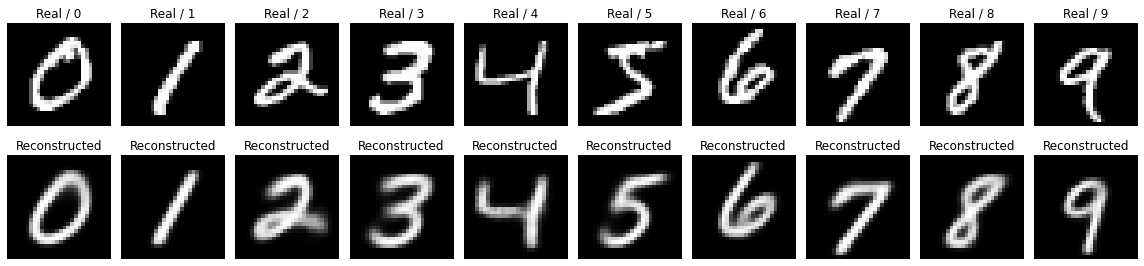

In [26]:
batch_images = torch.FloatTensor()
for i in range(10):
    for j in train_dataset:
        if j[1] == i:
            image = torch.FloatTensor(j[0]).unsqueeze(0)
            batch_images = torch.cat((batch_images, image), dim=0)
            break
reconstructed_val, _, _ = cvaeautoencoder(batch_images.to(device), torch.LongTensor(list(range(10))))

fig, ax = plt.subplots(2, 10, figsize=(16, 4))
for i in range(10):
    for j in train_dataset:
        if j[1] == i:
            image = torch.FloatTensor(j[0]).unsqueeze(0)
            ax[0, i].imshow(torch.squeeze(image.cpu()), cmap='gray')
            ax[0, i].axis('off')
            ax[0, i].set_title('Real / '+ str(i))
            ax[1, i].imshow(torch.squeeze(reconstructed_val[i].detach().cpu()), cmap='gray')
            ax[1, i].axis('off')
            ax[1, i].set_title('Reconstructed')
            break
plt.tight_layout()
plt.show()

### Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

In [ ]:
#<тут нужно научиться сэмплировать из декодера цифры определенного класса>

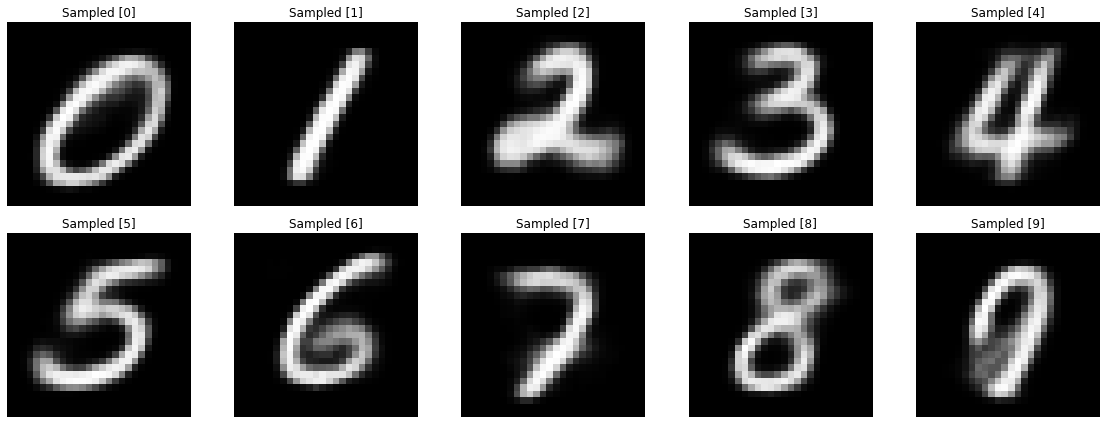

In [27]:
z = torch.randn(1, cvae_latent_dim)
z = torch.tile(z, dims=(10, 1))
labels = torch.LongTensor(list(range(10)))
cvaeautoencoder.eval()
with torch.no_grad():
    output = cvaeautoencoder.decode(z.to(device), labels.to(device))
fig, ax = plt.subplots(2, 5, figsize=(16, 6))
for i in range(2):
    for j in range(5):
        axes = ax[i, j]
        axes.imshow(output[5*i+j].cpu().squeeze(0), cmap='gray')
        axes.set_title(f'Sampled {[5*i+j]}')
        axes.axis('off')
plt.tight_layout()
plt.show()

Splendid! Вы великолепны!


### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

In [ ]:
#<ваш код получения латентных представлений, применения TSNE и визуализации>

In [28]:
latents = torch.FloatTensor()

for batch in test_loader:
    images, labels = batch
    cvaeautoencoder.eval()
    with torch.no_grad():
        latent = cvaeautoencoder.get_latent_vector(images.to(device), labels.to(device))
    latents = torch.cat((latents, latent.cpu()))

In [33]:
latents_tsne = TSNE(n_components=2).fit_transform(latents)

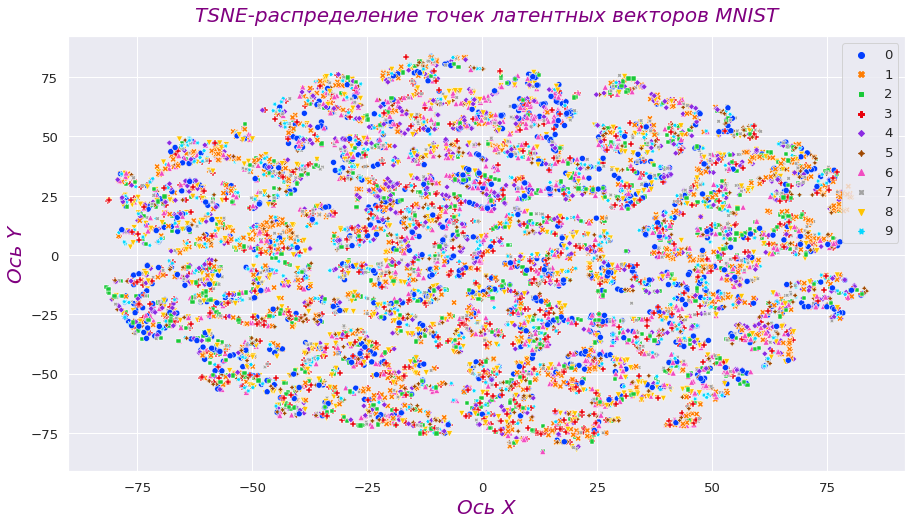

In [34]:
labels = [i[1] for i in test_dataset]
fig, ax = plt.subplots()
sns.set(rc={'figure.figsize': (15, 8)}, font_scale=1.2, style='darkgrid')
sns.scatterplot(x = latents_tsne[:, 0], y = latents_tsne[:, 1], hue=labels, palette='bright', style=labels)
ax.set_title('TSNE-распределение точек латентных векторов MNIST', fontsize =20, color = 'purple', fontfamily = 'sans-serif', fontstyle = 'italic', pad = 15)
ax.set_xlabel('Ось X', fontsize =20, color = 'purple', fontfamily = 'sans-serif', fontstyle = 'italic')
ax.set_ylabel('Ось Y', fontsize =20, color = 'purple', fontfamily = 'sans-serif', fontstyle = 'italic')
plt.show()

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

Дислокация признаков латентного пространства на двухмерной TSNE плоскости носит распределенный характер, не позволяющий осуществить их уверенную кластеризацию. При этом, объекты кодируются соответствующими метками, которые позволяют декодеру интерпретировать любую точку скрытого пространства в соответствие с заданной меткой класса. Полученный графический вывод можно назвать как пространство стилей, которые описывают единые, общие характеристики различных изображений.

# BONUS 1: Denoising

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них эта бонусная часть задания.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума. 
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

Для этого нужно взять ваш любимый датасет (датасет лиц из первой части этого задания или любой другой) и сделать копию этого датасета с шумом. 

В питоне шум можно добавить так:

In [ ]:
#noise_factor = 0.5
#X_noisy = X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X.shape) 

In [35]:
# Функция для добавления шума на изображения
def RandomNoise(img):
    noise_factor = 0.5
    img_noisy = img + noise_factor * torch.normal(0, 1, size=img.shape) 
    return torch.clip(img_noisy, 0, 1)

### Посмотрим как работает функция, добавляющая шум на изображение

In [ ]:
#<тут ваш код обучения автоэнкодера на зашумленных картинках. Не забудтье разбить на train/test!>

In [ ]:
images = next(iter(val_loader))
noise_images = RandomNoise(copy.deepcopy(images)).to('cpu')

fig, ax = plt.subplots(2, 6, figsize=(16, 6))
for i in range(2):
    for j in range(6):
        axes = ax[i, j]
        if i == 0:
            axes.imshow(images[j].permute(1,2,0))
            axes.set_title('Real')
        else:
            axes.imshow(noise_images[j].permute(1,2,0))
            axes.set_title('Noised')
        axes.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
def train_noise(model_noise, optimizer, epochs=epochs, learning_rate=lr, used_sheduler=True):

    # Set default parameters for saving model weights
    best_model_weights = model_noise.state_dict()
    best_loss_val = np.inf

    if used_sheduler:
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.95)

    criterion = nn.MSELoss() # mean square error loss

    outputs = []
    train_losses = []
    val_losses = []
    person = file_attrs['person'].tail(5).values.tolist()

    for epoch in range(epochs):

        model_noise.train()  # trainmodel_noise
        train_losses_per_epoch = []

        for data in train_loader:
            img_noise_train = RandomNoise(copy.deepcopy(data))
            img_train = data.to(device)
            img_noise_train = img_noise_train.to(device)

            # set parameter gradients to zero
            optimizer.zero_grad()
            recon, _ = model_noise(img_noise_train)
            loss = criterion(recon, img_train) # forward-pass
            loss.backward()  # backward-pass
            optimizer.step()  # update weights
            train_losses_per_epoch.append(loss.item())

        train_losses.append(np.mean(train_losses_per_epoch))

        if used_sheduler:
            scheduler.step()

        model_noise.eval()
        val_losses_per_epoch = []
        with torch.no_grad():
            for data in val_loader:
              img_noise_val = RandomNoise(copy.deepcopy(data))
              img_val = data.to(device)
              img_noise_val = img_noise_val.to(device)
              recon_val, _ = model_noise(img_noise_val)
              loss_val = criterion(recon_val, img_val)
              val_losses_per_epoch.append(loss_val.item())
        val_losses.append(np.mean(val_losses_per_epoch))
        outputs.append((epoch, img_val, recon_val),)

        # Save best model weights
        if val_losses[epoch] < best_loss_val:
            best_loss_val = val_losses[epoch]
            best_model_weights = copy.deepcopy(model_noise.state_dict())

        # Visualize tools
        clear_output(wait=True)

        fig = plt.figure(figsize=(12,6))
        fig.suptitle('%d / %d - train_loss: %f , val_loss: %f' % (epoch+1, epochs, np.mean(train_losses_per_epoch), np.mean(val_losses_per_epoch)),
                     y=1, fontsize = 16)

        gs1 = GridSpec(2, 5, left=0.0001, right=1.0, wspace=0.05)
        ax1 = fig.add_subplot(gs1[:-1, :1])
        ax2 = fig.add_subplot(gs1[:-1, 1])
        ax3 = fig.add_subplot(gs1[:-1, 2])
        ax4 = fig.add_subplot(gs1[:-1, 3])
        ax5 = fig.add_subplot(gs1[:-1, -1])

        ax6 = fig.add_subplot(gs1[-1, :1])
        ax7 = fig.add_subplot(gs1[-1, 1])
        ax8 = fig.add_subplot(gs1[-1, 2])
        ax9 = fig.add_subplot(gs1[-1, 3])
        ax10 = fig.add_subplot(gs1[-1, 4])

        gs2 = GridSpec(2, 2, left=1.1, right=2.0, hspace=0.05)
        ax11 = fig.add_subplot(gs2[:, :-1])

        axis =[ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11]
        for k in range(11):
          if k < 5:
              axis[k].imshow(img_noise_val[k].detach().cpu().permute(1,2,0))
              axis[k].set_title('Real + Noise')
              axis[k].grid(False)
              axis[k].axis('off')
          elif 4 < k < 10:
              axis[k].imshow(recon_val[k-5].detach().cpu().permute(1,2,0))
              axis[k].set_title('Denoised')
              axis[k].grid(False)
              axis[k].axis('off')
          else:
              axis[k].plot(np.arange(len(train_losses)), train_losses, label='Train', color = "green")
              axis[k].plot(np.arange(len(val_losses)), val_losses, label='Validation', color = "orange")
              axis[k].set_xlabel('Epoch')
              axis[k].set_title('MSE loss', fontsize = 16)
              axis[k].legend()
              axis[k].legend(fontsize = 14)
              axis[k].grid(linestyle = "--")
              axis[k].tick_params(labelsize = 14)
              axis[k].set_xlabel("Epoch", fontsize = 14)
              axis[k].set_ylabel("Loss", fontsize = 14)
              axis[k].set_xlim(left = 0, right = len(train_losses))
              axis[k].set_ylim(bottom = 0, top = max(max(train_losses), max(val_losses))*1.2)

        #plt.tight_layout()
        plt.show()

    # load best model weights
    model_noise.load_state_dict(best_model_weights)

   # очистка кеша

    data.to("cpu")
    img_train.to("cpu")
    recon.to("cpu")
    model_noise.to("cpu")
    del data
    del img_train
    del recon
    del model_noise
    torch.cuda.empty_cache()

    return outputs, train_losses, val_losses

In [ ]:
#<тут проверка, как AE убирает щум с тестовых картинок. Надеюсь, все получилось =)>

In [ ]:
model_noise = Autoencoder().to(device)
optimizer = torch.optim.AdamW(model_noise.parameters(),lr=lr, betas=(0.9, 0.999), eps=1e-8, weight_decay=1e-5, amsgrad=False)
outputs, train_losses, val_losses = train_noise(model_noise, optimizer)

In [ ]:
# Сохраняем веса модели
torch.save(model_noise.state_dict(), Path(str(BASE_DIR) + str('/VanillaAE_noise')))

# BONUS 2: Image Retrieval

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

Давайте представим, что весь наш тренировочный датасет -- это большая база данных людей. И вот мы получили картинку лица какого-то человека с уличной камеры наблюдения (у нас это картинка из тестового датасета) и хотим понять, что это за человек. Что нам делать? Правильно -- берем наш VAE, кодируем картинку в латентное представление и ищем среди латентныз представлений лиц нашей базы самые ближайшие!

План:

1. Получаем латентные представления всех лиц тренировочного датасета
2. Обучаем на них LSHForest `(sklearn.neighbors.LSHForest)`, например, с `n_estimators=50`
3. Берем картинку из тестового датасета, с помощью VAE получаем ее латентный вектор
4. Ищем с помощью обученного LSHForest ближайшие из латентных представлений тренировочной базы
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализируем!

Немного кода вам в помощь: (feel free to delete everything and write your own)

#### Задание выполнено при использовании Vanilla AE (пайплайн обучения см. выше в 1-ом разделе работы)

In [ ]:
#codes = <поучите латентные представления картинок из трейна>

In [ ]:
# Получим латентные представления всех лиц тренировочного датасета
latents = torch.FloatTensor()
iterator = iter(train_loader)
for i in range(len(train_loader)):
    images = next(iterator)
    model.eval()
    with torch.no_grad():
        _, latent = model(images.to(device))
    latents = torch.cat((latents, latent.cpu()))

In [ ]:
def get_test_latent(image):
    '''Получает на вход изображение,
    возвращает латентное представление изображения'''
    image = image.unsqueeze(0)
    model.eval()
    with torch.no_grad():
        _, latent = model(image.to(device))
    return latent

In [ ]:
def get_similar_latents(n_neighbors, latents, test_latent):
    '''Получает на вход количество соседей, latents и latent тестового изображения, 
    возвращает batch латентных векторов ближайщих к тестовому и массив с дистанциями'''
    
    nnbrs = NearestNeighbors(n_neighbors=5).fit(latents)
    distances, num_latents = nnbrs.kneighbors(test_latent.to('cpu'), n_neighbors=n_neighbors)
    n_latents = torch.FloatTensor() 
    
    for i in num_latents:
        n_latents = torch.cat((n_latents, latents[i].cpu()))
            
    return distances, n_latents, num_latents

In [ ]:
def show_similar(test_image, n_latents, distances, num_latents):
    '''Принимает на вход тестовое изображение, latents ближайщих к тестовому
    изображений массив с дистанциями и массив индексов латентных представлений,
    отрисовывает результат'''
 
    plt.figure(figsize=[16, 12])
    plt.subplot(3,4,1)
    plt.imshow(test_image.cpu().numpy().transpose([1,2,0]))
    plt.xticks([])
    plt.yticks([])
    plt.title(f"{'Original image'}")
    
    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(train_photos_t[num_latents[0][i]].cpu().numpy().transpose([1,2,0]))
        plt.xticks([])
        plt.yticks([])
        plt.title(f"{file_attrs['person'].iloc[num_latents[0][i]]}, \n Distance={round(distances[0][i])}")
    plt.show()

In [ ]:
k=18
test_image = next(iter(val_loader))[k]
plt.imshow(test_image.cpu().permute(1,2,0))
plt.title(f"{file_attrs['person'][k]}")
plt.show()

In [ ]:
test_latent = get_test_latent(test_image)
distances, n_latents, num_latents = get_similar_latents(11, latents, test_latent)
show_similar(test_image, n_latents, distances, num_latents)

In [ ]:
# обучаем LSHForest
#from sklearn.neighbors import LSHForest
#lshf = LSHForest(n_estimators=50).fit(codes)

In [ ]:
#def get_similar(image, n_neighbors=5):
  # функция, которая берет тестовый image и с помощью метода kneighbours у LSHForest ищет ближайшие векторы
  # прогоняет векторы через декодер и получает картинки ближайших людей

  #code = <получение латентного представления image>
    
  #(distances,),(idx,) = lshf.kneighbors(code, n_neighbors=n_neighbors)

  #return distances, X_train[idx]

In [ ]:
#def show_similar(image):

  # функция, которая принимает тестовый image, ищет ближайшие к нему и визуализирует результат
    
    #distances,neighbors = get_similar(image,n_neighbors=11)
    
    #plt.figure(figsize=[8,6])
    #plt.subplot(3,4,1)
    #plt.imshow(image.cpu().numpy().transpose([1,2,0]))
    #plt.title("Original image")
    
    #for i in range(11):
        #plt.subplot(3,4,i+2)
        #plt.imshow(neighbors[i].cpu().numpy().transpose([1,2,0]))
        #plt.title("Dist=%.3f"%distances[i])
    #plt.show()

In [ ]:
#<тут выведите самые похожие лица к какому-нибудь лицу из тестовой части датасета>